In [11]:
import os
import sys
import math
import time
import gzip
import random

import numpy as np
import pandas as pd
pd.set_option("display.max_columns",50)

import matplotlib.pyplot as plt
import seaborn as sns
PATH='~/Dropbox/cooperative/crystallinePolymer/data'

## サンプル情報 ##

In [12]:
sample_list = pd.read_csv(os.path.join(PATH, 'SampleInfo.csv'), index_col=0, dtype={'CrystTemp': int, 'CrysTime': int, 'Cooling': bool})
sample_list['NucConc'] = sample_list['NucConc'].round(3)
#sample_list.T

## 応力-歪曲線 ##
breaking energy/MJ*m-3  :  破壊エネルギー (破談までの応力-歪曲線の面積)  
Yield stress/MPa  :  降伏応力 (応力が低下し始める応力)  
Strain at break  :  破断歪み(破断するときの歪み)  
<font color="Red">それぞれの物性への効果は要確認(どれを一番重要視する？)<font>

In [13]:
sscurve = pd.read_csv(os.path.join(PATH, 'tensiletest','2','55d','summary.csv'))
sscurve['SampleNo']=sscurve.index+1
sscurve=sscurve.set_index('SampleNo')
sscurve.T

SampleNo,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84
breaking energy/MJ*m-3,34.503814,32.121068,1.551187,5.379902,0.335198,13.765413,18.480124,2.501082,4.074421,11.472479,2.356883,2.058195,1.37793,4.323672,4.710164,1.727741,32.037666,32.260685,68.971093,60.127447,16.396725,14.801069,40.111897,27.263505,28.942233,...,4.305505,4.937591,3.866334,2.876108,4.023488,6.148313,4.05838,3.017879,0.570719,2.330615,3.337933,8.251314,3.845631,2.352315,2.200302,3.738191,1.050669,2.003845,2.405548,3.006595,2.528114,29.493143,25.988296,23.968642,25.579586
Yield stress/MPa,9.894200,10.583800,39.517800,27.835100,12.155200,16.943000,31.296300,32.764700,33.698272,30.280577,36.789800,33.459300,32.47280,29.226200,29.303000,29.062500,3.931600,4.383300,17.312500,13.989900,2.418500,1.149700,22.426900,25.198900,3.472200,...,33.857900,33.571400,32.286600,37.994400,34.923500,19.713400,30.54490,32.716800,27.081600,29.742900,33.070200,31.812500,32.919100,34.261400,32.645300,32.381000,32.222200,31.967200,32.359600,32.921700,33.359400,3.848300,3.119300,2.454000,3.086100
Strain at break,3.836300,2.310200,0.056000,0.273100,0.073200,0.829800,0.698300,0.137600,0.202400,0.444200,0.090000,0.092700,0.06170,0.177200,0.185600,0.081500,4.166700,4.166700,4.166700,3.814100,4.166700,4.166700,2.292900,1.339300,4.166700,...,0.149000,0.168700,0.151900,0.126500,0.135300,0.456300,0.17440,0.115100,0.047600,0.095600,0.120800,0.318000,0.151900,0.092600,0.084300,0.143400,0.056200,0.084300,0.092800,0.129600,0.092700,4.166700,4.166700,4.166700,4.166700


In [14]:
enzyme = pd.read_csv(os.path.join(PATH, 'enzyme','test1.csv'), index_col=0)
sample_info=pd.merge(sample_list.query('SampleNo>16 & SampleNo<81'),sscurve,
                      how='left',left_index=True,right_index=True)\
    .merge(enzyme,how="left", left_index=True, right_on="SampleNo")

降伏応力が酵素分解率とトレードオフの関係(っぽい）ので  
降伏応力と関係の一番強い 影響を与える成形プロセスを線形回帰でみてみる

## 降伏応力 ##


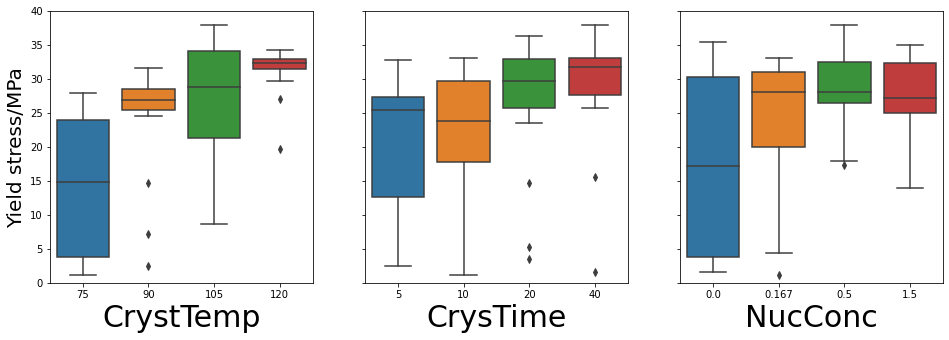

In [16]:
print("## 降伏応力 ##")
fig, axs =plt.subplots(nrows=1, ncols=3,figsize=(16, 5))
#結晶化温度 CrystTemp
sns.boxplot(x='CrystTemp', y='Yield stress/MPa', data=sample_info, ax=axs[0])

#結晶化時間 CrysTime
sns.boxplot(x='CrysTime', y='Yield stress/MPa', data=sample_info, ax=axs[1])

#核材の量 NucConc
sns.boxplot(x='NucConc', y='Yield stress/MPa', data=sample_info, ax=axs[2])

for col in [0,1,2] : 
    axs[col].set_ylim(0, 40)
    axs[col].xaxis.label.set_size(fontsize=30)
    axs[col].yaxis.label.set_size(fontsize=20)


for col in [1,2] :
    axs[col].yaxis.set_ticklabels([])
    axs[col].set_ylabel('')


#p value
#p_value=[tempp,timep,nucp]
#for col in [0,1,2] :
#    p=p_value[col*3+row]
#    axs[row,col].text(1,0.1,'p value='+str(p/10000))
            
#色は変えるべきかも...

## 破壊エネルギー ##


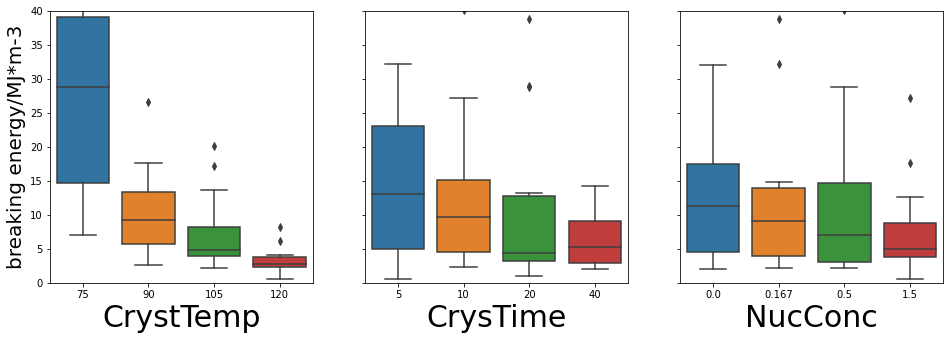

In [17]:
print("## 破壊エネルギー ##")
#破壊エネルギー
fig, axs =plt.subplots(nrows=1, ncols=3,figsize=(16, 5))
#結晶化温度 CrystTemp
sns.boxplot(x='CrystTemp', y='breaking energy/MJ*m-3', data=sample_info, ax=axs[0])

#結晶化時間 CrysTime
sns.boxplot(x='CrysTime', y='breaking energy/MJ*m-3', data=sample_info, ax=axs[1])

#核材の量 NucConc
sns.boxplot(x='NucConc', y='breaking energy/MJ*m-3', data=sample_info, ax=axs[2])

for col in [0,1,2] : 
    axs[col].set_ylim(0, 40)
    axs[col].xaxis.label.set_size(fontsize=30)
    axs[col].yaxis.label.set_size(fontsize=20)


for col in [1,2] :
    axs[col].yaxis.set_ticklabels([])
    axs[col].set_ylabel('')

## 破断歪み ##


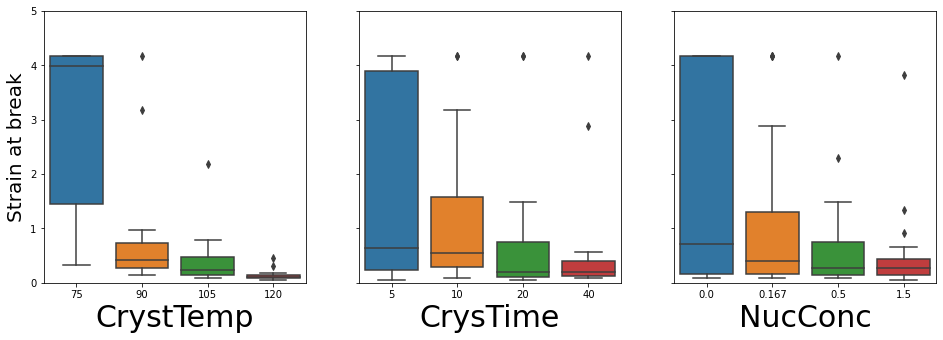

In [19]:
print("## 破断歪み ##")
#破断歪み
fig, axs =plt.subplots(nrows=1, ncols=3,figsize=(16, 5))
#結晶化温度 CrystTemp
sns.boxplot(x='CrystTemp', y='Strain at break', data=sample_info, ax=axs[0])

#結晶化時間 CrysTime
sns.boxplot(x='CrysTime', y='Strain at break', data=sample_info, ax=axs[1])

#核材の量 NucConc
sns.boxplot(x='NucConc', y='Strain at break', data=sample_info, ax=axs[2])

for col in [0,1,2] : 
    axs[col].set_ylim(0, 5)
    axs[col].xaxis.label.set_size(fontsize=30)
    axs[col].yaxis.label.set_size(fontsize=20)


for col in [1,2] :
    axs[col].yaxis.set_ticklabels([])
    axs[col].set_ylabel('')

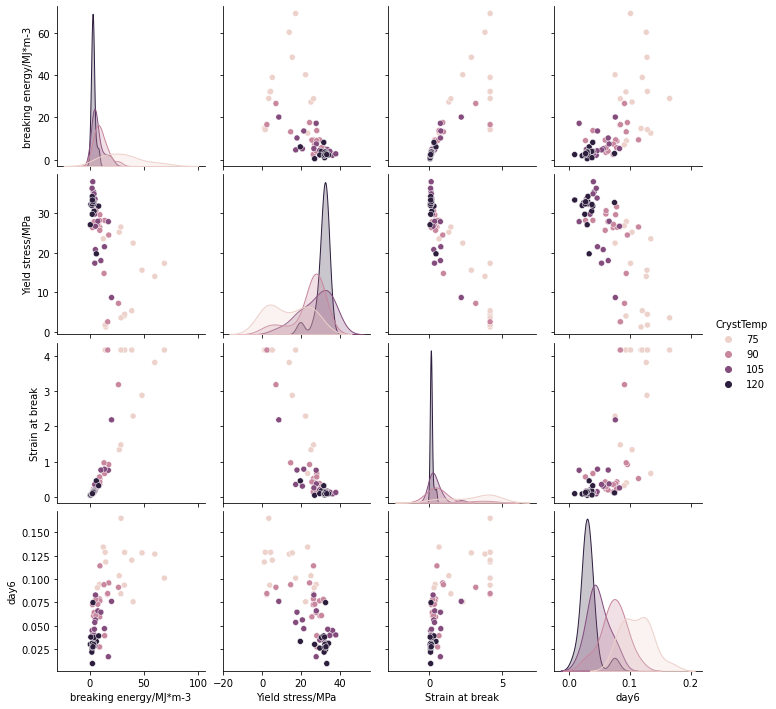

In [10]:
#enzyme-day6のデータを加えた散布図行列を書いてみる(SampleNo 16-80 のみで)
sns.pairplot(sample_info,hue='CrystTemp',
            vars=['breaking energy/MJ*m-3','Yield stress/MPa','Strain at break','day6'])